In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import pickle
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from bayes_opt import BayesianOptimization
from imbalanced_evaluation import eval_report

(CVXPY) Aug 01 04:13:50 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 01 04:13:50 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# Load data
X_train_smote = pd.read_csv("../03_outputs/01/X_train_smote.csv")
y_train_smote = pd.read_csv("../03_outputs/01/y_train_smote.csv")
X_train = pd.read_csv("../03_outputs/01/train3.csv", index_col="Unnamed: 0")
y_train = pd.read_csv("../03_outputs/01/y_train.csv", index_col="Unnamed: 0")
X_test = pd.read_csv("../03_outputs/01/test3.csv", index_col="Unnamed: 0")
y_test = pd.read_csv("../03_outputs/01/y_test.csv", index_col="Unnamed: 0")

In [13]:
# Make scorer
auc_score = make_scorer(roc_auc_score)

# Feature selection

In [21]:
# Hyperparameter-tuning: Bayesian Optimization
def xgb_cl_bo(n_estimators, learning_rate, gamma, max_depth, min_child_weight, subsample, colsample_bytree):
    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric':'auc',
        'nthread':-1
    }
    params_xgb['n_estimators'] = round(n_estimators)
    params_xgb['learning_rate'] = learning_rate
    params_xgb['gamma'] = gamma
    params_xgb['max_depth'] = round(max_depth)
    params_xgb['min_child_weight'] = round(min_child_weight)
    params_xgb['subsample'] = subsample
    params_xgb['colsample_bytree'] = colsample_bytree
    
    skf = StratifiedKFold(10, shuffle=True, random_state=12).split(X_train_smote.index, y_train_smote)
    scores = cross_val_score(
        XGBClassifier(random_state=123, **params_xgb), X_train_smote, y_train_smote, scoring=auc_score, cv=skf
    ).mean()
    
    return scores


params_xgb = {
    'n_estimators':(10, 30),
    'learning_rate': (0.001, 0.1),
    'gamma':(0, 10),
    'max_depth': (10, 30),
    'min_child_weight':(3, 50),
    'subsample':(0.8, 1),
    'colsample_bytree':(0.8, 1),
}

# Run Bayesian Optimization
xgb_bo = BayesianOptimization(xgb_cl_bo, params_xgb, random_state=123)
xgb_bo.maximize(init_points=5, n_iter=15)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.5343    | 0.9393    | 2.861     | 0.02346   | 21.03     | 36.82     | 18.46     | 0.9962    |
| 2         | 0.5302    | 0.937     | 4.809     | 0.03982   | 16.86     | 37.27     | 18.77     | 0.8119    |
| 3         | 0.5467    | 0.8796    | 7.38      | 0.01907   | 13.51     | 27.98     | 20.64     | 0.9269    |
| 4         | 0.5882    | 0.9699    | 7.245     | 0.06149   | 24.45     | 18.18     | 17.24     | 0.8457    |
| 5         | 0.5526    | 0.8587    | 6.31      | 0.01012   | 18.67     | 23.25     | 19.87     | 0.8852    |
| 6         | 0.6199    | 1.0       | 8.299     | 0.09598   | 29.05     | 12.85     | 15.11     | 0.8232    |
| 7         | 0.7462    | 1.0       | 0.0       | 0.1       | 30.0      | 3.0       | 10.0      | 1.0       |
| 8       

In [22]:
# Best hyperparameters
params_xgb_opt = xgb_bo.max['params']
params_xgb_opt['objective'] = 'binary:logistic'
params_xgb_opt['eval_metric'] = 'auc'
params_xgb_opt['n_jobs'] = -1
params_xgb_opt['n_estimators'] = int(round(params_xgb_opt['n_estimators']))
params_xgb_opt['learning_rate'] = round(params_xgb_opt['learning_rate'], 3)
params_xgb_opt['gamma'] = int(round(params_xgb_opt['gamma']))
params_xgb_opt['max_depth'] = int(round(params_xgb_opt['max_depth']))
params_xgb_opt['min_child_weight'] = int(round(params_xgb_opt['min_child_weight']))
params_xgb_opt['subsample'] = round(params_xgb_opt['subsample'], 2)
params_xgb_opt['colsample_bytree'] = round(params_xgb_opt['colsample_bytree'], 2)
params_xgb_opt

{'colsample_bytree': 1.0,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 30,
 'subsample': 1.0,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'n_jobs': -1}

In [23]:
# Fit the model
xgb_selection = XGBClassifier(**params_xgb_opt, random_state=123, nthread=-1)
xgb_selection.fit(X_train_smote, y_train_smote)
pred_smote_selection = xgb_selection.predict_proba(X_train_smote)[:, 1]
pred_train_selection = xgb_selection.predict_proba(X_train)[:, 1]
pred_test_selection = xgb_selection.predict_proba(X_test)[:, 1]

Feature selection, SMOTE


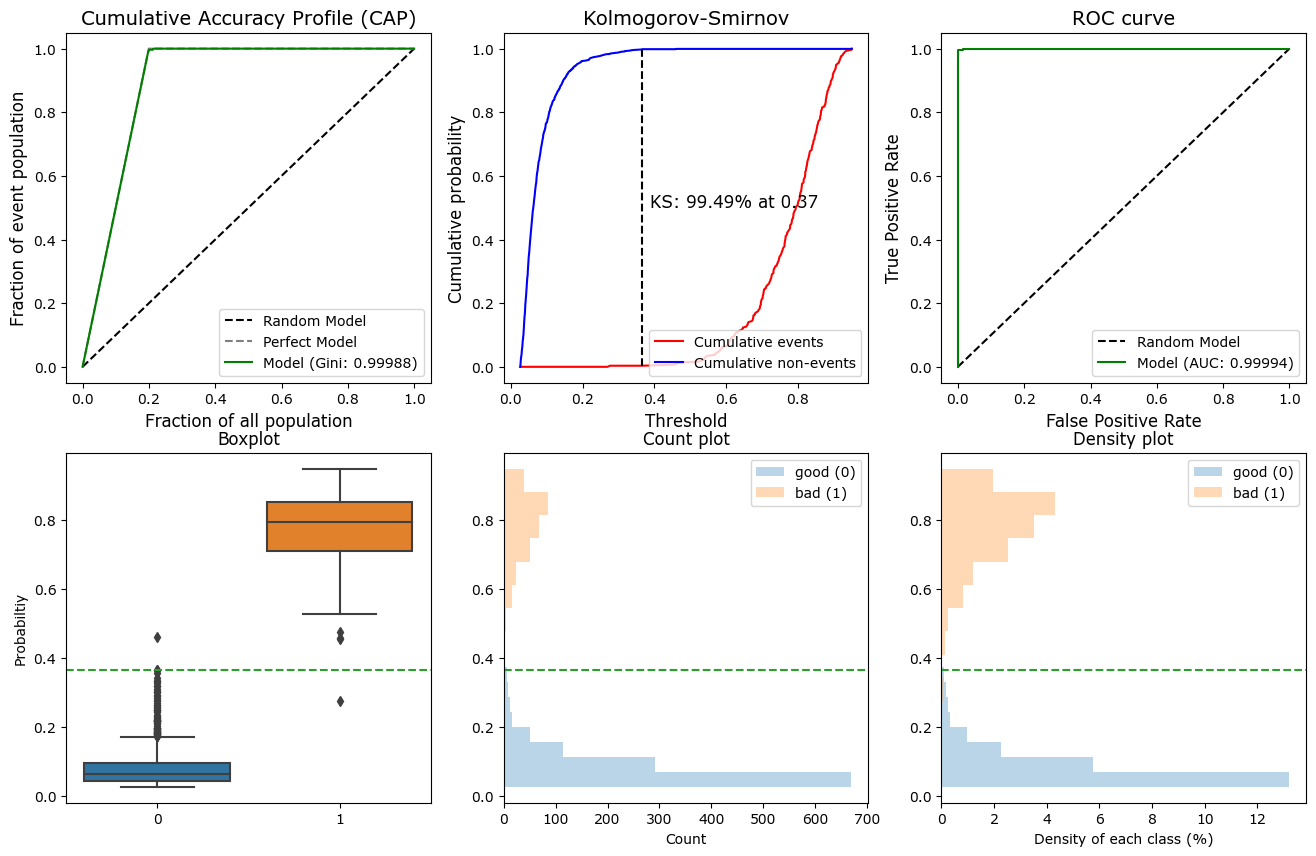

Probability threshold: 0.366
confusion_matrix
      0    1
0  1168    2
1     1  291

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1170
           1       0.99      1.00      0.99       292

    accuracy                           1.00      1462
   macro avg       1.00      1.00      1.00      1462
weighted avg       1.00      1.00      1.00      1462



In [24]:
eval_report(
    y_train_smote.index,
    y_train_smote["label"],
    pred_smote_selection,
    'Feature selection, SMOTE',
)

Feature selection, train


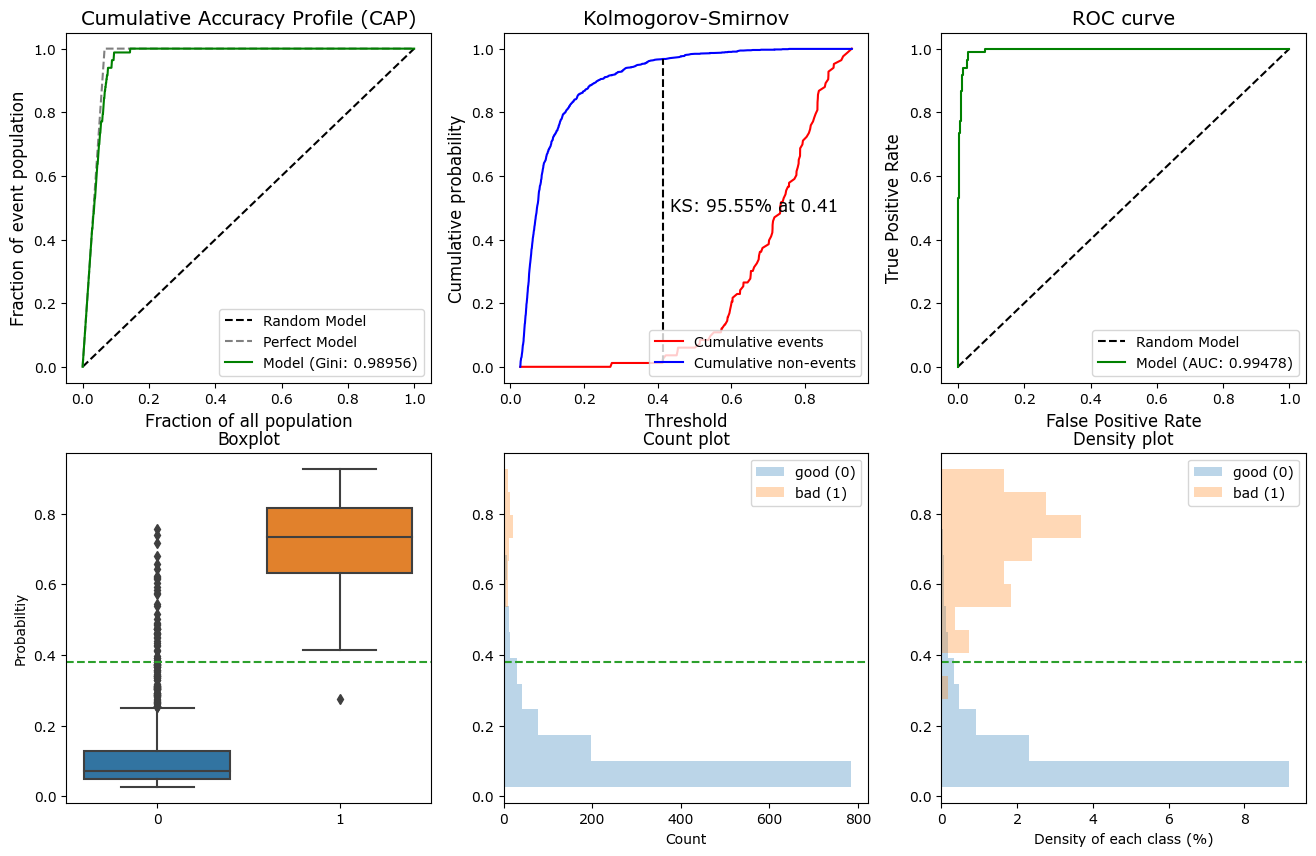

Probability threshold: 0.38
confusion_matrix
      0   1
0  1126  44
1     1  82

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1170
           1       0.65      0.99      0.78        83

    accuracy                           0.96      1253
   macro avg       0.82      0.98      0.88      1253
weighted avg       0.98      0.96      0.97      1253



In [25]:
eval_report(
    y_train.index,
    y_train["label"],
    pred_train_selection,
    'Feature selection, train',
)

Feature selection, test


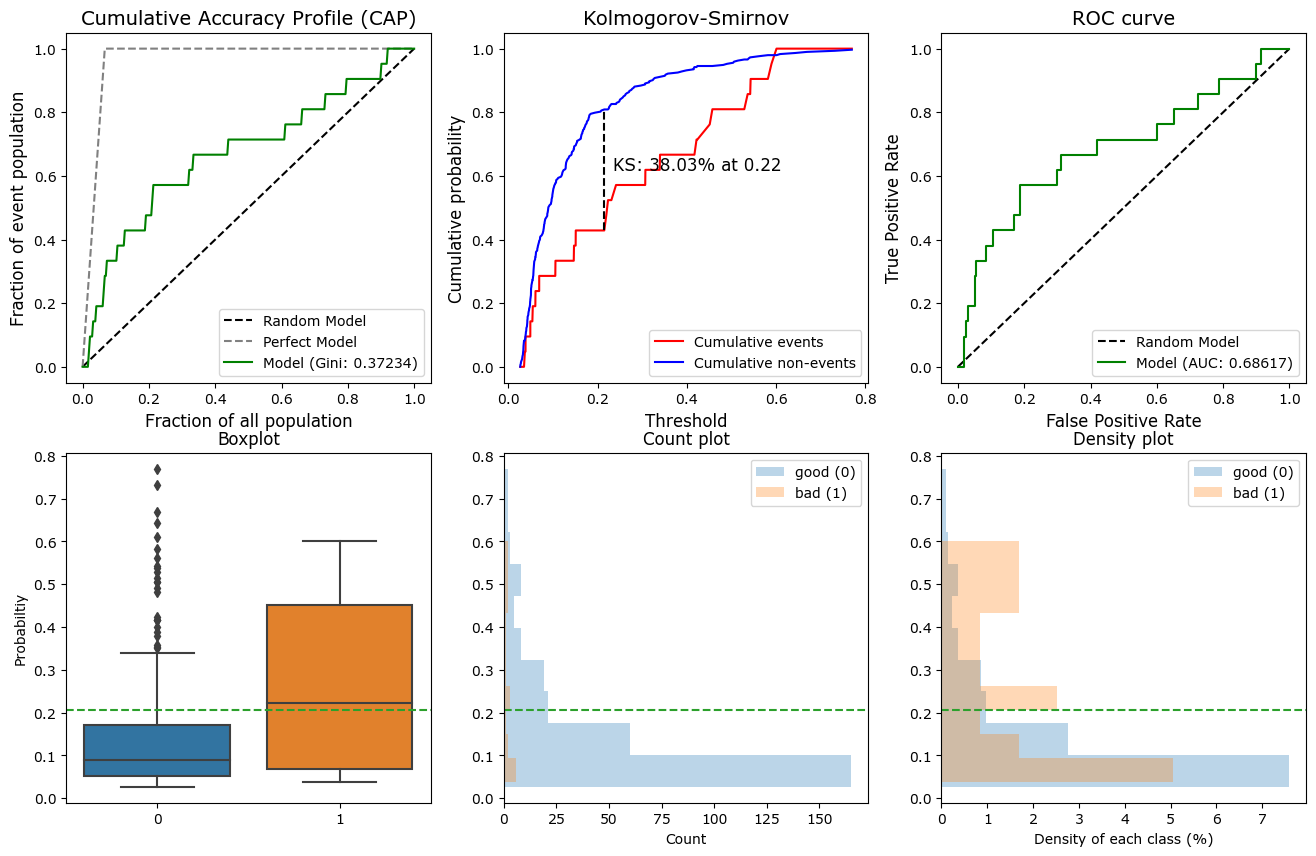

Probability threshold: 0.207
confusion_matrix
     0   1
0  236  57
1    9  12

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       293
           1       0.17      0.57      0.27        21

    accuracy                           0.79       314
   macro avg       0.57      0.69      0.57       314
weighted avg       0.91      0.79      0.84       314



In [26]:
eval_report(
    y_test.index,
    y_test["label"],
    pred_test_selection,
    'Feature selection, test',
    
)

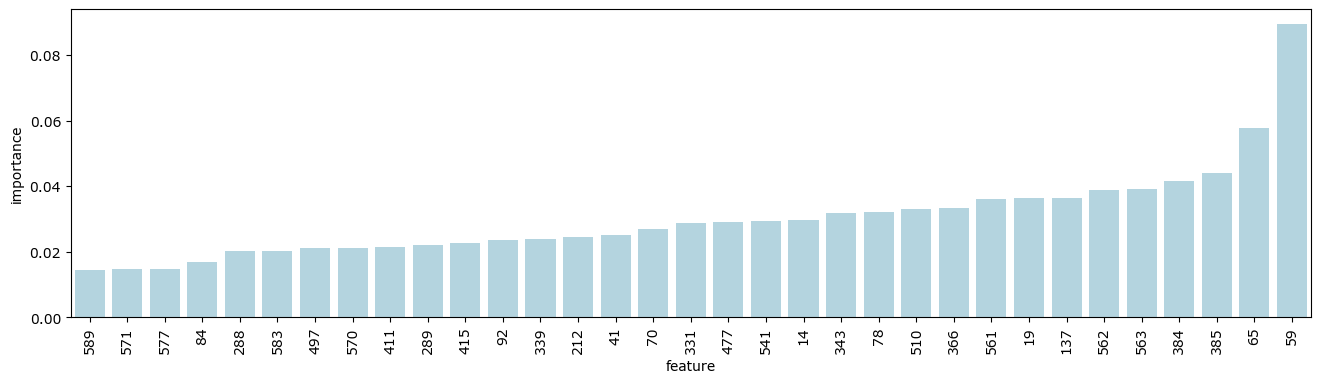

In [27]:
# Feature importances
feature_df = pd.DataFrame({'feature':X_train_smote.columns, 'importance':list(xgb_selection.feature_importances_)}).sort_values('importance')
plt.figure(figsize=(16,4))
sns.barplot(data=feature_df, x='feature', y='importance', color="lightblue")
plt.xticks(rotation=90)
plt.show()

In [28]:
# Select top 10 features
selected_feat = feature_df.tail(10)["feature"].to_list()
selected_feat

['366', '561', '19', '137', '562', '563', '384', '385', '65', '59']

# Train model

In [29]:
# Hyperparameter-tuning: Bayesian Optimization
def xgb_cl_bo(n_estimators, learning_rate, gamma, max_depth, min_child_weight, subsample, colsample_bytree):
    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric':'auc',
        'nthread':-1
    }
    params_xgb['n_estimators'] = round(n_estimators)
    params_xgb['learning_rate'] = learning_rate
    params_xgb['gamma'] = gamma
    params_xgb['max_depth'] = round(max_depth)
    params_xgb['min_child_weight'] = round(min_child_weight)
    params_xgb['subsample'] = subsample
    params_xgb['colsample_bytree'] = colsample_bytree
    
    skf = StratifiedKFold(5, shuffle=True, random_state=12).split(X_train_smote.index, y_train_smote)
    
    scores = cross_val_score(
        XGBClassifier(random_state=123, **params_xgb),
        X_train_smote[selected_feat], y_train_smote, scoring=auc_score, cv=skf
    ).mean()
    
    return scores

# Run Bayesian Optimization
xgb_bo = BayesianOptimization(xgb_cl_bo, params_xgb, random_state=123)
xgb_bo.maximize(init_points=5, n_iter=15)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.5335    | 0.9393    | 2.861     | 0.02346   | 21.03     | 36.82     | 18.46     | 0.9962    |
| 2         | 0.5091    | 0.937     | 4.809     | 0.03982   | 16.86     | 37.27     | 18.77     | 0.8119    |
| 3         | 0.5493    | 0.8796    | 7.38      | 0.01907   | 13.51     | 27.98     | 20.64     | 0.9269    |
| 4         | 0.5729    | 0.9699    | 7.245     | 0.06149   | 24.45     | 18.18     | 17.24     | 0.8457    |
| 5         | 0.54      | 0.8587    | 6.31      | 0.01012   | 18.67     | 23.25     | 19.87     | 0.8852    |
| 6         | 0.5888    | 1.0       | 8.807     | 0.09338   | 26.57     | 17.13     | 15.74     | 0.8153    |
| 7         | 0.6032    | 1.0       | 7.063     | 0.1       | 29.96     | 12.28     | 15.15     | 0.8397    |
| 8       

In [30]:
# Best hyperparameters
params_xgb_opt = xgb_bo.max['params']
params_xgb_opt['objective'] = 'binary:logistic'
params_xgb_opt['eval_metric'] = 'auc'
params_xgb_opt['n_jobs'] = -1
params_xgb_opt['n_estimators'] = int(round(params_xgb_opt['n_estimators']))
params_xgb_opt['learning_rate'] = round(params_xgb_opt['learning_rate'], 3)
params_xgb_opt['gamma'] = int(round(params_xgb_opt['gamma']))
params_xgb_opt['max_depth'] = int(round(params_xgb_opt['max_depth']))
params_xgb_opt['min_child_weight'] = int(round(params_xgb_opt['min_child_weight']))
params_xgb_opt['subsample'] = round(params_xgb_opt['subsample'], 2)
params_xgb_opt['colsample_bytree'] = round(params_xgb_opt['colsample_bytree'], 2)
params_xgb_opt

{'colsample_bytree': 1.0,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 3,
 'n_estimators': 30,
 'subsample': 1.0,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'n_jobs': -1}

In [31]:
# Fit the model
xgb_model = XGBClassifier(**params_xgb_opt, random_state=123, nthread=-1)
xgb_model.fit(X_train_smote[selected_feat], y_train_smote)
pred_smote = xgb_model.predict_proba(X_train_smote[selected_feat])[:, 1]
pred_train = xgb_model.predict_proba(X_train[selected_feat])[:, 1]
pred_test = xgb_model.predict_proba(X_test[selected_feat])[:, 1]

In [ ]:
X_test[:1][selected_feat]

,366,561,19,137,562,563,384,385,65,59
415,0.0029,71.0573,12.4722,55.1,248.928,0.8157,NaN,0.0076,18.2879,8.3018


In [ ]:
pred_test[:1]

array([0.15029776], dtype=float32)

Result, SMOTE


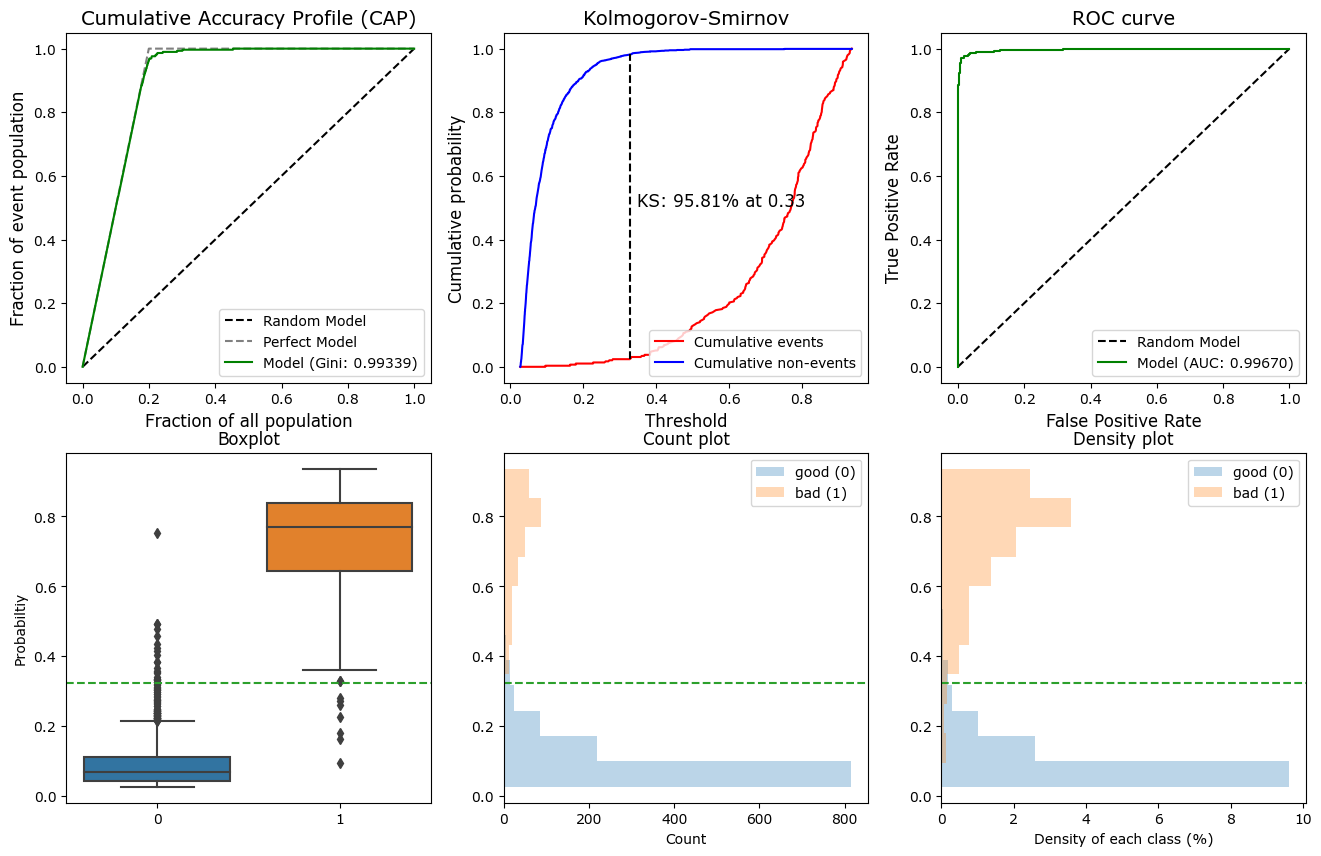

Probability threshold: 0.323
confusion_matrix
      0    1
0  1148   22
1     7  285

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1170
           1       0.93      0.98      0.95       292

    accuracy                           0.98      1462
   macro avg       0.96      0.98      0.97      1462
weighted avg       0.98      0.98      0.98      1462



In [32]:
eval_report(
    y_train_smote.index,
    y_train_smote["label"],
    pred_smote,
    'Result, SMOTE',
)

Result, train


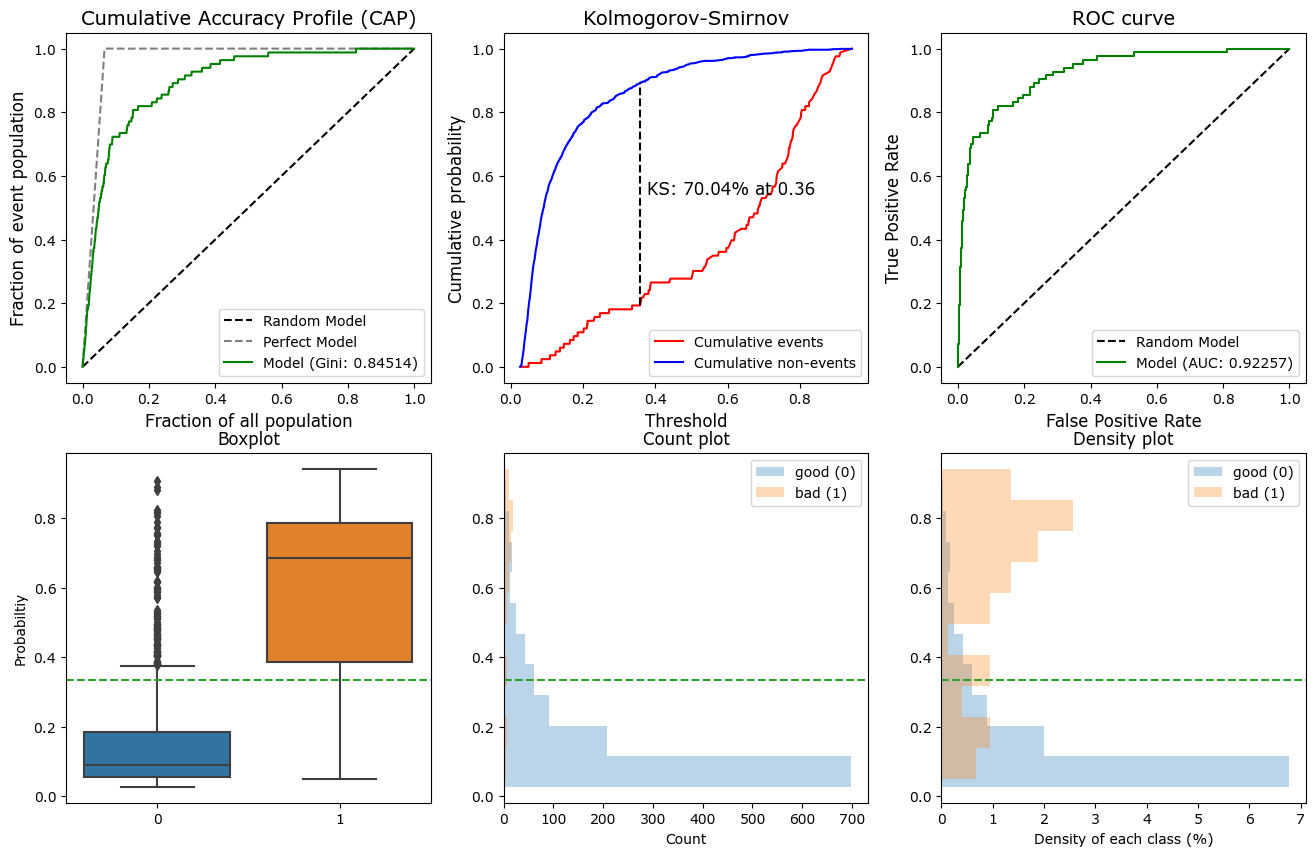

Probability threshold: 0.334
confusion_matrix
      0    1
0  1024  146
1    15   68

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1170
           1       0.32      0.82      0.46        83

    accuracy                           0.87      1253
   macro avg       0.65      0.85      0.69      1253
weighted avg       0.94      0.87      0.90      1253



In [33]:
eval_report(
    y_train.index,
    y_train["label"],
    pred_train,
    'Result, train',
)

Result, test


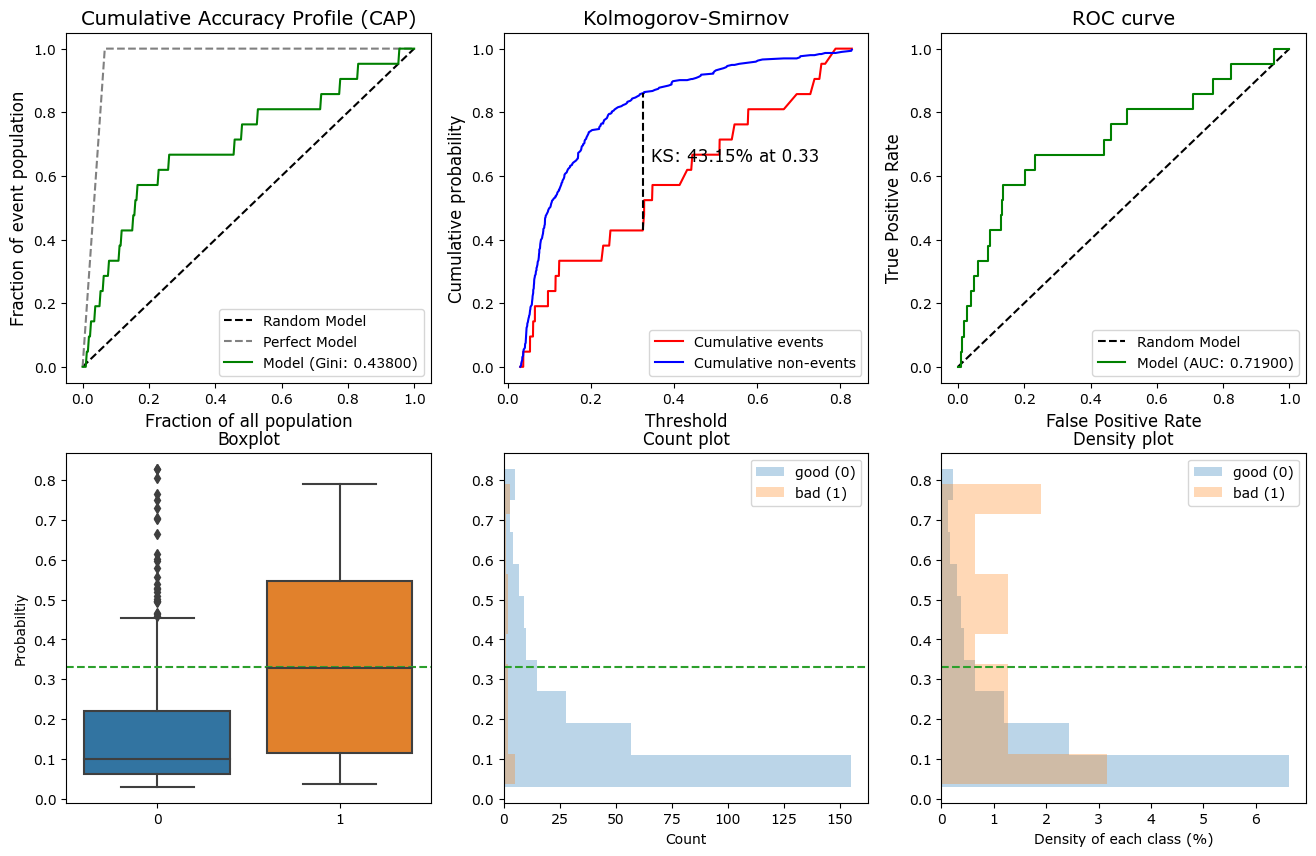

Probability threshold: 0.33
confusion_matrix
     0   1
0  254  39
1   11  10

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       293
           1       0.20      0.48      0.29        21

    accuracy                           0.84       314
   macro avg       0.58      0.67      0.60       314
weighted avg       0.91      0.84      0.87       314



In [45]:
eval_report(
    y_test.index,
    y_test["label"],
    pred_test,
    'Result, test',
    0.33
)

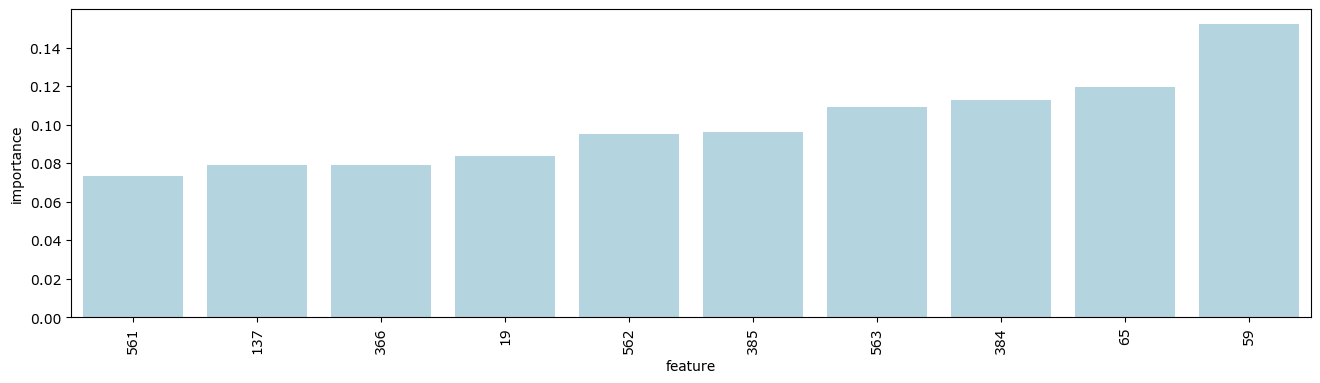

In [37]:
# Feature importances
feature_df = pd.DataFrame(
    {
        'feature':X_train_smote[selected_feat].columns,
        'importance':list(xgb_model.feature_importances_)
    }
).sort_values('importance')
plt.figure(figsize=(16,4))
sns.barplot(data=feature_df, x='feature', y='importance', color="lightblue")
plt.xticks(rotation=90)
plt.show()

In [35]:
# Save model
pickle.dump(xgb_model, open("../03_outputs/02/xgb_model.pkl", "wb"))

This notebook trains a binary classification Machine Learning model using the Extreme Gradient Boosting (Xgboost) algorithm. The model predicts whether a semiconductor chip is a "pass" or "fail" from given signals. The first Xgboost model is trained with 33 features. Then, the 10 strongest features are selected based on the feature importance. Feature importance shows which features are important in building the model.

The selected 10 features are used to train another Xgboost model. The hyperparameter tuning uses Bayesian Optimization. The tuning focuses on increasing the ROC AUC score. A set of hyperparameters are found and used to develop an optimum predictive model. The model prediction returns a probability ranging from 0 to 1 where 0 means "pass" and 1 means "fail". The probability threshold is 0.33 based on the Kolmogorov-Smirnov chart. If the probability is above 0.33, then the sample is a "fail".

The prediction result is analyzed with the ROC Curve, Cumulative Accuracy Profile, Kolmogorov-Smirnov, Confusion Matrix, and Classification Report. The ROC AUC score of the testing dataset is 0.719. A no-skill model has an ROC AUC score of 0.5. A good model should have an ROC AUC score closer to 1.

The model still needs further development. It can detect "pass" samples well with the f1-score of 0.91. However, it has a problem in detecting "fail" samples with the f1-score of 0.29.